# CREATE SYNTHETIC LC OF A TRANSIT WITH BATMAN
**needed packages:**    
numpy    
matplotlib    
batman-package    

Basic import and set:

In [1]:
%matplotlib inline
import numpy as np
seed = 12093481
np.random.seed(seed=seed)
import matplotlib.pyplot as plt
import os
import batman as btm

Define the main-output folder path, the file with parameters, and final lc file.

In [2]:
main_folder = os.path.abspath('/data2/borsato/LC/test/2018-02-27_test_sc') # sc: shortcadence , lc: longcadence
if(not os.path.isdir(main_folder)): os.makedirs(main_folder)
par_file = os.path.join(main_folder, 'transit_par_true.in')

Define the parameters and write them to file par_file

In [3]:
# needed parameters
Msun = 1.9884e30 # Sun mass in kg
Mear = 5.9722e24 # Earth mass in kg
Me2s = Mear/Msun
Rsun = 696000. #  Sun radius in km
Rear = 6378.1366 # Earth radius in km
Re2s = Rear/Rsun #  Rear to Rsun
texp = 5. # exposure time of 5 seconds (sc) or 1800 seconds (== 30 min , lc)
Mstar = [1., -0.05, +0.05] # Msun
Rstar = [1., -0.05, +0.05] # Rsun
Mpl_earth = 317.8 # ~1 Mjup in Mearth
Rpl_earth = 10.97 # 1 Rjup in Rearth 
P_days = 3.55 # Period in days
ecc = 0. # zero eccentricity
inc = 89.8 # inclination in deg
argp = 90. # fixed argument of pericentre
u_lin = 0.45 # linear LD
u_quad = 0.1 # quadratic LD
k = Rpl_earth * Re2s / Rstar[0]
# save to file
opar = open(par_file, 'w')
opar.write("lc_folder = %s\n" %(main_folder))
opar.write("lc_file = UPDATEMEWITHHDF5FILE\n")
opar.write("lc_type = mag\n")
opar.write("lc_texp = %.1fs\n" %(texp))
opar.write("k = U %.4f\n" %(k))
opar.write("per = F %.6f\n" %(P_days))
opar.write("ecc = F %.3f\n" %(ecc))
opar.write("inc = U %.4f\n" %(inc))
opar.write("argp = F %.4f\n" %(argp))
opar.write("u_lin = U %.4f\n" %(u_lin))
opar.write("u_quad = U %.4f\n" %(u_quad))
opar.write("mstar_msun = G %.4f %.4f %.4f\n" %(Mstar[0], Mstar[1], Mstar[2]))
opar.write("rstar_rsun = G %.4f %.4f %.4f\n" %(Rstar[0], Rstar[1], Rstar[2]))
opar.write("fit_type = l_det\n")
opar.write("# emcee\n")
opar.write("delta = 1.e-5\n")
opar.write("nthreads = 3\n")
opar.write("nwalkers = 50\n")
opar.write("nsteps = 20000\n")
opar.write("nsave = 10000\n")
opar.close()

We neeed the `a/Rstar` parameter as input of batman-package, and so we have to compute the semi-major axis, `a`, from `P_days`, `Mstar`, and `Mpl_earth`.


In [4]:
def per2sma(per, mstar_s, mpl_e):
    kappa = 0.01720209895 # Gaussian gravitational constant
    Giau = kappa*kappa
    tpi2 = 4.*np.pi*np.pi
    p2 = per*per
    mu = Giau * (mstar_s + mpl_e*Me2s)
    sma_au = ( (mu*p2) / tpi2)**(1./3.) # sma in au
    return sma_au
sma = per2sma(P_days, Mstar[0], Mpl_earth)
AU = 149597870700. #Astronomical Unit in meters
RsunAU = (Rsun*1.e3)/AU #Sun radius in AU
aRs = sma/(Rstar[0]*RsunAU)

We define the transit model centred on the Transit Time, `TT=0.5*P_days`, with steps of `texp`.

In [5]:
TT = 0.5*P_days # linear ephemeris like, transit 0
texp_d = texp / 86400. # from seconds to days
t = np.arange(0., P_days+texp_d*0.5, texp_d) # span 1 period
params = btm.TransitParams()
params.t0 = TT
params.per = P_days
params.rp = k
params.a = aRs
params.inc = inc
params.ecc = ecc
params.w = argp
params.u = [u_lin, u_quad]
params.limb_dark = 'quadratic'
btm_mod = btm.TransitModel(params, t)
f_mod = btm_mod.light_curve(params)
mag_mod = -2.5*np.log10(f_mod)

plot the lc model

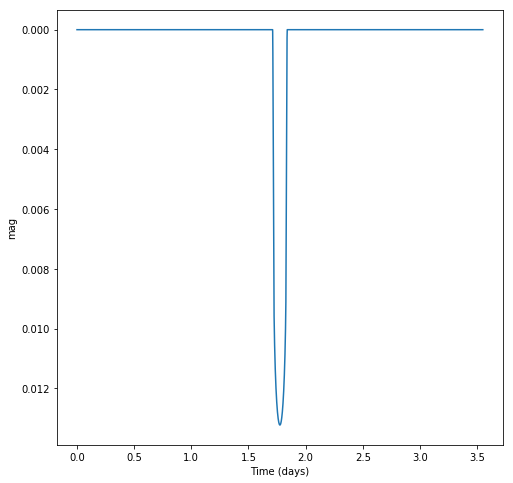

In [6]:
def limits(v,d=0.05):
    vmin, vmax = np.min(v), np.max(v)
    delta = vmax-vmin
    lmin = vmin - delta*d
    lmax = vmax + delta*d
    return lmin, lmax
ymin, ymax = limits(mag_mod)
plt.figure(figsize=(8,8))
plt.plot(t, mag_mod, marker='None', ls='-')
plt.ylim([ymax, ymin])
plt.xlabel('Time (days)')
plt.ylabel('mag')

Now we define a function that add noise and a linear trend and save the model, the noisy lc, and the noise+trend lc into 3 files.
We have to define sigma_noise, that will be a Gaussian noise, the coeff. a0 e a1 that is y = a0 + a1*(t-t[0]).

In [7]:
def noisy_and_trendy_lc(ilc, t, mag, s_noise, a0, a1, mod_file, noise_file, out_file):
    dt = t-t[0]
    pp = t[-1] - t[0]
    dpp = 0.1
    TT = np.median(t)
    npts = np.shape(t)[0]
    m_noise = np.random.normal(loc=0., scale=s_noise, size=npts)
    print "Created noise"
    n_std = np.std(m_noise, ddof=1)
    m_std = np.zeros((npts)) + n_std
    print "Computed std of noise: it defines the errors of each datapoints. std = %.6f" %(n_std)
    m_trend = a0 + a1*dt
    print "Computed linear trend"
    m_out = mag + m_noise + m_trend
    print "Created noisy & trendy lc"
    
    np.savetxt(mod_file, np.column_stack((t, mag)), fmt="%23.16e %23.16e", header='TIME_DAYS MAG')
    print "Saved clean model (no noise, no linear trend) to file %s" %(mod_file)
    
    headn = 'INPUT NOISE = %.6f\nTIME_DAYS MAG ERR_MAG' %(s_noise)
    np.savetxt(noise_file, np.column_stack((t, mag+m_noise, m_std)), fmt="%23.16e %23.16e %23.16e", header=headn)
    print "Saved model with noise (no linear trend) to file %s" %(noise_file)
    
    headt = 'INPUT NOISE = %.6f & LINEAR TREND a0 = %.6f a1 = %.6f\nTIME_DAYS MAG ERR_MAG' %(s_noise, a0, a1)
    np.savetxt(out_file, np.column_stack((t, m_out, m_std)), fmt="%23.16e %23.16e %23.16e", header=headt)
    print "Saved model with noise & linear trend to file %s" %(out_file)
    
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    
    ax0.errorbar(t, mag+m_noise, yerr=m_std,
                 marker='o', ms=4, ls='', 
                 ecolor='lightgrey', elinewidth = 1.3, capsize=0, capthick=0.,
                 zorder=6
                )
    ax0.plot(t, mag, marker='', ls='-', color='C1', zorder=7)
    nmin, nmax = limits(mag+m_noise)
    ax0.set_xlim([TT-pp*dpp, TT+pp*dpp])
    ax0.set_ylim([nmax+n_std, nmin-n_std])
    ax0.set_xlabel('TIME (days)')
    ax0.set_ylabel('mag')
    ax0.set_title('LC%03d noise added' %(ilc+1))
    
    ax1.errorbar(t, m_out, yerr=m_std,
                 marker='o', ms=4, ls='', 
                 ecolor='lightgrey', elinewidth = 1.3, capsize=0, capthick=0.,
                 zorder=6
                )
    ax1.plot(t, mag+m_trend, marker='', ls='-', color='C1', zorder=7)
    omin, omax = limits(m_out)
    ax1.set_xlim([TT-pp*dpp, TT+pp*dpp])
    ax1.set_ylim([omax, omin])
    ax1.set_xlabel('TIME (days)')
    ax1.set_ylabel('mag')
    ax1.set_title('LC%03d noise & linear trend added' %(ilc+1))
    
    return m_noise, m_std, m_trend, m_out

We will provide 3 different values of noise and linear trend, that will be saved into different files. We will add also a period to shift the LC.


COMPUTING LC 1
Created noise
Computed std of noise: it defines the errors of each datapoints. std = 0.002496
Computed linear trend
Created noisy & trendy lc
Saved clean model (no noise, no linear trend) to file /data2/borsato/LC/test/2018-02-27_test_lc/lc001_mod_mag.dat
Saved model with noise (no linear trend) to file /data2/borsato/LC/test/2018-02-27_test_lc/lc001_noise_mag.dat
Saved model with noise & linear trend to file /data2/borsato/LC/test/2018-02-27_test_lc/lc001_final_mag.dat

COMPUTING LC 2
Created noise
Computed std of noise: it defines the errors of each datapoints. std = 0.002990
Computed linear trend
Created noisy & trendy lc
Saved clean model (no noise, no linear trend) to file /data2/borsato/LC/test/2018-02-27_test_lc/lc002_mod_mag.dat
Saved model with noise (no linear trend) to file /data2/borsato/LC/test/2018-02-27_test_lc/lc002_noise_mag.dat
Saved model with noise & linear trend to file /data2/borsato/LC/test/2018-02-27_test_lc/lc002_final_mag.dat

COMPUTING LC 3
Cr

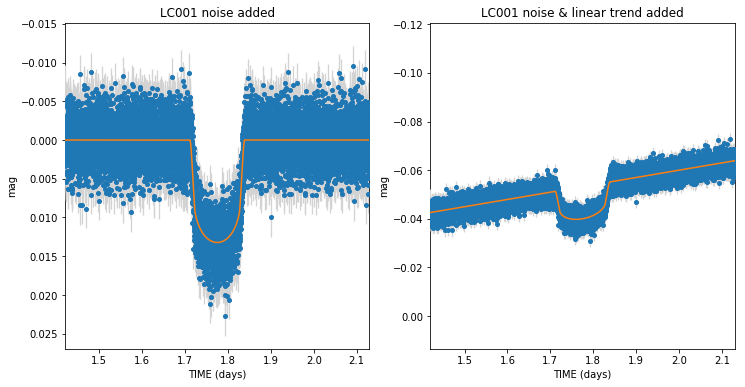

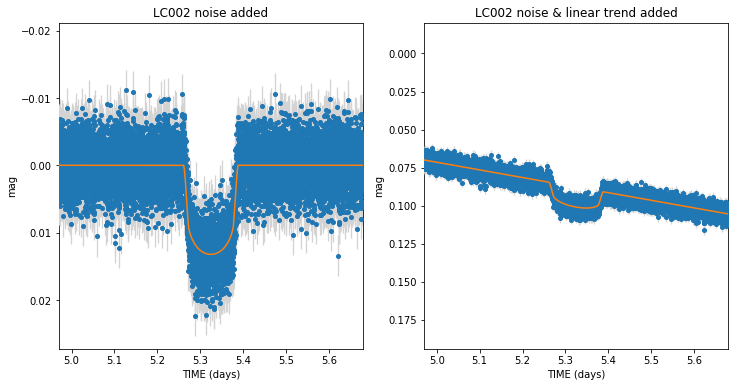

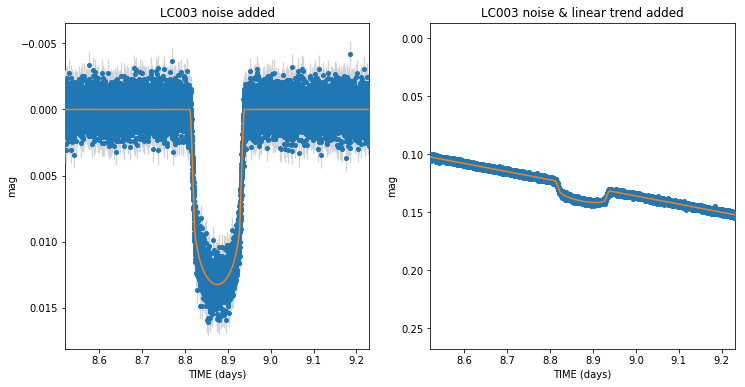

In [22]:
sigma_noise = [0.0025, 0.003, 0.001]
a0 = [0., -0.001, 0.003]
a1 = [-0.03, 0.05, 0.07]
lc_t, lc_m_noise, lc_m_std, lc_m_trend, lc_m_out = [], [], [], [], []
nlc = len(sigma_noise)
for ilc in range(0, nlc):
    print '\nCOMPUTING LC %d' %(ilc+1)
    dP = ilc*P_days
    new_t = t + dP
    lc_mod_file = os.path.join(main_folder, 'lc%03d_mod_mag.dat' %(ilc+1))
    lc_noise_file = os.path.join(main_folder, 'lc%03d_noise_mag.dat' %(ilc+1))
    lc_out_file = os.path.join(main_folder, 'lc%03d_final_mag.dat' %(ilc+1))
    m_noise, m_std, m_trend, m_out = \
      noisy_and_trendy_lc(ilc, new_t, mag_mod, sigma_noise[ilc], a0[ilc], a1[ilc],
                          lc_mod_file, lc_noise_file, lc_out_file)
    lc_t.append(new_t)
    lc_m_noise.append(m_noise)
    lc_m_std.append(m_std)
    lc_m_trend.append(m_trend)
    lc_m_out.append(m_out)
    

Create a long cadence (lc) model by binning the short cadence (sc) to texp = 1800s.


COMPUTING BINNED LC 1
Saved BINNED clean model (no noise, no linear trend) to file /data2/borsato/LC/test/2018-02-27_test_lc/lc001_mod_mag.dat
Saved BINNED model with noise (no linear trend) to file /data2/borsato/LC/test/2018-02-27_test_lc/lc001_noise_mag.dat
Saved BINNED model with noise & linear trend to file /data2/borsato/LC/test/2018-02-27_test_lc/lc001_final_mag.dat

COMPUTING BINNED LC 2
Saved BINNED clean model (no noise, no linear trend) to file /data2/borsato/LC/test/2018-02-27_test_lc/lc002_mod_mag.dat
Saved BINNED model with noise (no linear trend) to file /data2/borsato/LC/test/2018-02-27_test_lc/lc002_noise_mag.dat
Saved BINNED model with noise & linear trend to file /data2/borsato/LC/test/2018-02-27_test_lc/lc002_final_mag.dat

COMPUTING BINNED LC 3
Saved BINNED clean model (no noise, no linear trend) to file /data2/borsato/LC/test/2018-02-27_test_lc/lc003_mod_mag.dat
Saved BINNED model with noise (no linear trend) to file /data2/borsato/LC/test/2018-02-27_test_lc/lc00

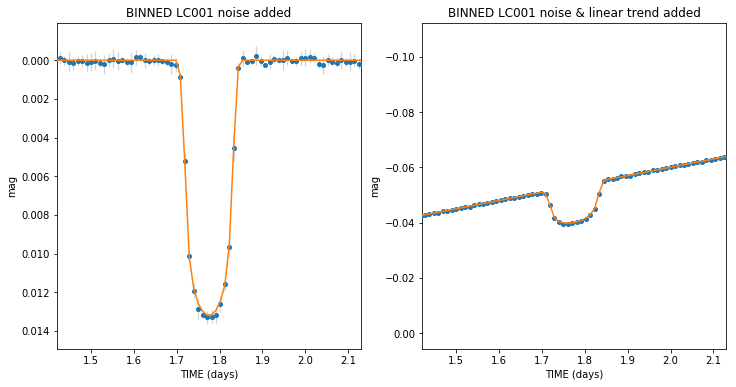

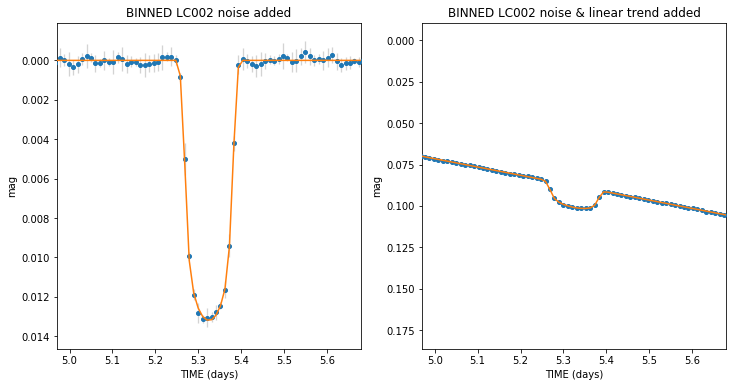

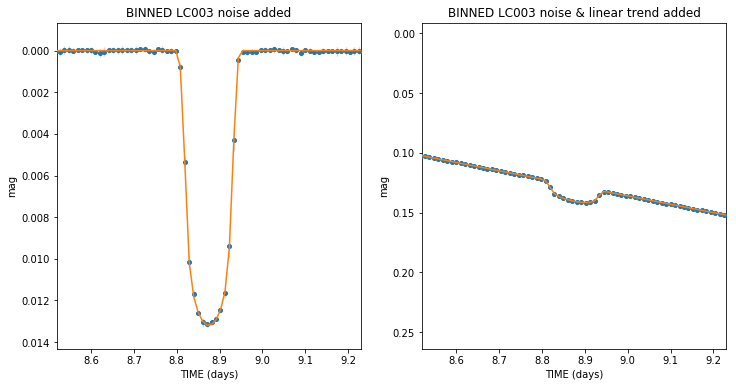

In [23]:
main_folder = os.path.abspath('/data2/borsato/LC/test/2018-02-27_test_lc') # sc: shortcadence , lc: longcadence
if(not os.path.isdir(main_folder)): os.makedirs(main_folder)
tbin = 1800. / 86400. # seconds == 30 min
thbin = 0.5*tbin
# define a function that given tmin e tmax select the t and m values and computes median and rms
def sel_to_bin(x, y, minx, maxx):
  
  selx = np.logical_and(x >= minx, x < maxx)
  nsel = np.sum(np.asarray(selx, dtype=bool))
  if(nsel > 1):
    # median way
    #medy = np.percentile(y[selx], 50., interpolation='midpoint')
    #rmsy = np.percentile(np.abs(y[selx] - medy), 68.27, interpolation='midpoint')/np.sqrt(nsel)
    # mean way
    medy = np.mean(y[selx])
    rmsy = np.std(y[selx], ddof=1)/np.sqrt(nsel)
    # worsening rmsy of a factor
    rmsy = (1.+np.random.random()*3.) * rmsy
  else:
    medy = None
    rmsy = None
  
  return medy, rmsy
def bin_and_check(x, y, xmid_bin, xhbin):
    nbins = np.shape(xmid_bin)[0]
    ybin = [sel_to_bin(x, y, xmid_bin[i]-xhbin, xmid_bin[i]+xhbin) for i in range(0, nbins)]
    ok = [i for i in range(0, nbins) if not ybin[i][0] is None]
    ybin = np.array(ybin, dtype=np.float64)[ok, :]
    xmid_out = xmid_bin[ok]
    return xmid_out, ybin[:,0], ybin[:,1]
    
# for each light curve bin, save, and plot
for ilc in range(0, nlc):
    print '\nCOMPUTING BINNED LC %d' %(ilc+1)
    # needed variables: lc_t, lc_m_noise, lc_m_std, lc_m_std, lc_m_out
    tmin, tmax = np.min(lc_t[ilc]), np.max(lc_t[ilc])
    pp = tmax - tmin
    dpp = 0.1
    TT = np.median(lc_t[ilc])
    
    tmid_bin_in = np.arange(tmin, tmax, thbin) + thbin
    
    
    tmid_bin, m_bin, _ = bin_and_check(lc_t[ilc], mag_mod, tmid_bin_in, thbin)
    lc_mod_file = os.path.join(main_folder, 'lc%03d_mod_mag.dat' %(ilc+1))
    np.savetxt(lc_mod_file, np.column_stack((tmid_bin, m_bin)), fmt="%23.16e %23.16e", header='TIME_DAYS MAG')
    print "Saved BINNED clean model (no noise, no linear trend) to file %s" %(lc_mod_file)
    
    _, m_noise_bin, em_noise_bin = bin_and_check(lc_t[ilc], mag_mod+lc_m_noise[ilc], tmid_bin_in, thbin)
    lc_noise_file = os.path.join(main_folder, 'lc%03d_noise_mag.dat' %(ilc+1))
    headn = 'INPUT NOISE = %.6f\nTIME_DAYS MAG ERR_MAG' %(sigma_noise[ilc])
    np.savetxt(lc_noise_file, np.column_stack((tmid_bin, m_noise_bin, em_noise_bin)), fmt="%23.16e %23.16e %23.16e", header=headn)
    print "Saved BINNED model with noise (no linear trend) to file %s" %(lc_noise_file)
    
    _, m_trend_bin, _ = bin_and_check(lc_t[ilc], lc_m_trend[ilc], tmid_bin_in, thbin)
    
    _, m_out_bin, em_out_bin = bin_and_check(lc_t[ilc], lc_m_out[ilc], tmid_bin_in, thbin)
    lc_out_file = os.path.join(main_folder, 'lc%03d_final_mag.dat' %(ilc+1))
    headt = 'INPUT NOISE = %.6f & LINEAR TREND a0 = %.6f a1 = %.6f\nTIME_DAYS MAG ERR_MAG' %(sigma_noise[ilc], a0[ilc], a1[ilc])
    np.savetxt(lc_out_file, np.column_stack((tmid_bin, m_out_bin, em_out_bin)), fmt="%23.16e %23.16e %23.16e", header=headt)
    print "Saved BINNED model with noise & linear trend to file %s" %(lc_out_file)
    
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    
    ax0.errorbar(tmid_bin, m_noise_bin, yerr=em_noise_bin,
                 marker='o', ms=4, ls='', 
                 ecolor='lightgrey', elinewidth = 1.3, capsize=0, capthick=0.,
                 zorder=6
                )
    ax0.plot(tmid_bin, m_bin, marker='', ls='-', color='C1', zorder=7)
    nmin, nmax = limits(m_noise_bin)
    ax0.set_xlim([TT-pp*dpp, TT+pp*dpp])
    ax0.set_ylim([nmax+np.max(em_noise_bin), nmin-np.max(em_noise_bin)])
    ax0.set_xlabel('TIME (days)')
    ax0.set_ylabel('mag')
    ax0.set_title('BINNED LC%03d noise added' %(ilc+1))
    
    ax1.errorbar(tmid_bin, m_out_bin, yerr=em_out_bin,
                 marker='o', ms=4, ls='', 
                 ecolor='lightgrey', elinewidth = 1.3, capsize=0, capthick=0.,
                 zorder=6
                )
    ax1.plot(tmid_bin, m_bin+m_trend_bin, marker='', ls='-', color='C1', zorder=7)
    omin, omax = limits(m_out_bin)
    ax1.set_xlim([TT-pp*dpp, TT+pp*dpp])
    ax1.set_ylim([omax+np.max(em_out_bin), omin-np.max(em_out_bin)])
    ax1.set_xlabel('TIME (days)')
    ax1.set_ylabel('mag')
    ax1.set_title('BINNED LC%03d noise & linear trend added' %(ilc+1))
    